## Demonstrating the DemandComponent Class
This notebook demonstrates how to use the `DemandComponent` class for scenario building in energy systems. We will showcase demand scenarios with:\
(a) Annual demand specified\
(b) Annual demand with a subannual demand profile\
(c) Annual and flexible demand specified

### 1. Import and Setup
First, import the class and set up a clean output directory for the demonstration.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.pardir)))

### 2. Scenario Setup
We will use the same regions, fuels, and time scale for both scenarios. The time scale will span 20 years.

In [2]:
import shutil
from pyoscomp.scenario.components.base import ScenarioComponent
from pyoscomp.scenario.components.demand import DemandComponent

# Set up a clean demo output directory
DEMO_DIR = "demo_output/demand_component"
if os.path.exists(DEMO_DIR):
    shutil.rmtree(DEMO_DIR)
os.makedirs(DEMO_DIR, exist_ok=True)

In [3]:
regions = ["North", "South", "East", "West"]
fuels = ["Electricity", "NaturalGas"]

### 3. Scenario 1: Annual Demand

In [4]:
# --- Scenario 1: Annual Demand ---
scenario1_dir = os.path.join(DEMO_DIR, "scenario1")
os.makedirs(scenario1_dir, exist_ok=True)

# Copy time component prerequisite from existing scenario (see demo.time.ipynb)
ScenarioComponent.copy("demo_output/time_component/uniform", scenario1_dir, overwrite=False)

# Copy topology component prerequisite from existing scenario (see demo.topology.ipynb)
ScenarioComponent.copy("demo_output/topology_component/custom", scenario1_dir, overwrite=False)

demand1 = DemandComponent(scenario1_dir)
# Add demand for each region and fuel with different interpolation types
for i, region in enumerate(regions):
    for j, fuel in enumerate(fuels):
        # Set trajectory (i.e. known demand values at specific years)
        trajectory = {
            2025: 1000 + 500*i + 250*j,
            2040: 3000 + 500*i + 250*j
        }
        # Set interpolation method between known values
        interp_options = ["linear", "cagr", "step"]
        interp = interp_options[(i + j) % 3]
        ## Alternatively, define a function to compute demand 
        def demand_estimate(year, base=1000+500*i+250*j):
            return base * (1.05 ** (year - 2025))

        # Add annual demand to the component
        demand1.add_annual_demand(region, fuel, trajectory=trajectory, interpolation=interp) # use this for interpolation-based demand
        # demand1.add_annual_demand(region, fuel, trajectory=trajectory, trend_function=demand_estimate) # use this for function-based demand
        # Note: Uncomment one of the above lines based on desired method
        # If both are provided in the same add_annual_demand() call, trend_function takes precedence
        # If add_annual_demand() is called multiple times for the same region-fuel, the last call overwrites previous entries

# Process and save the scenario
demand1.process()
demand1.save()

# Display the generated DataFrame
print("Annual Demand (Scenario 1):")
print(demand1.annual_demand_df.head())

Annual Demand (Scenario 1):
  REGION         FUEL  YEAR      VALUE
0  North  Electricity  2025  1000.0000
1  North  Electricity  2030  1500.0000
2  North  Electricity  2035  2000.0000
3  North  Electricity  2040  3000.0000
4  North  Electricity  2045  3666.6667


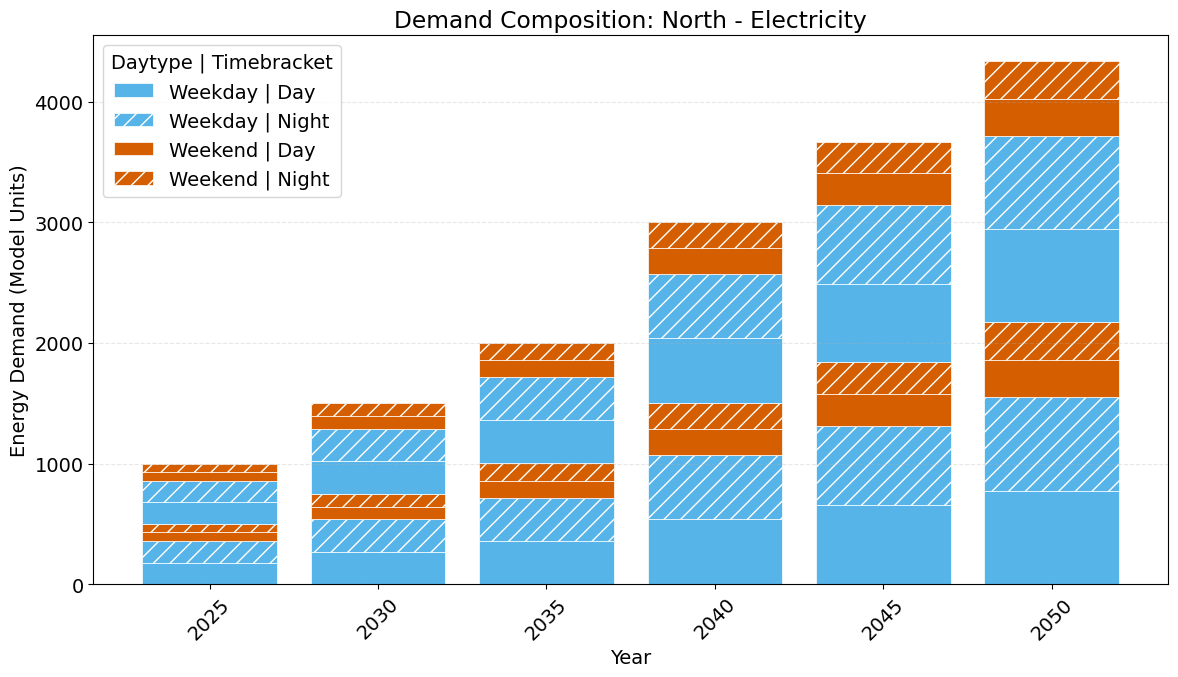

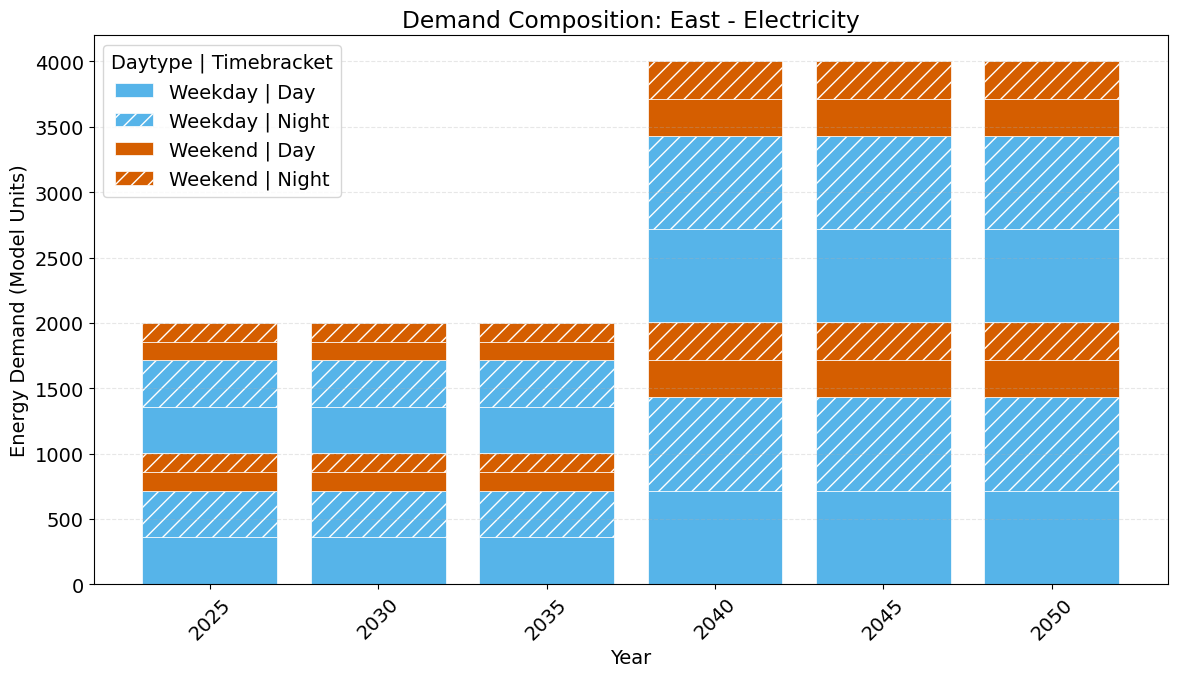

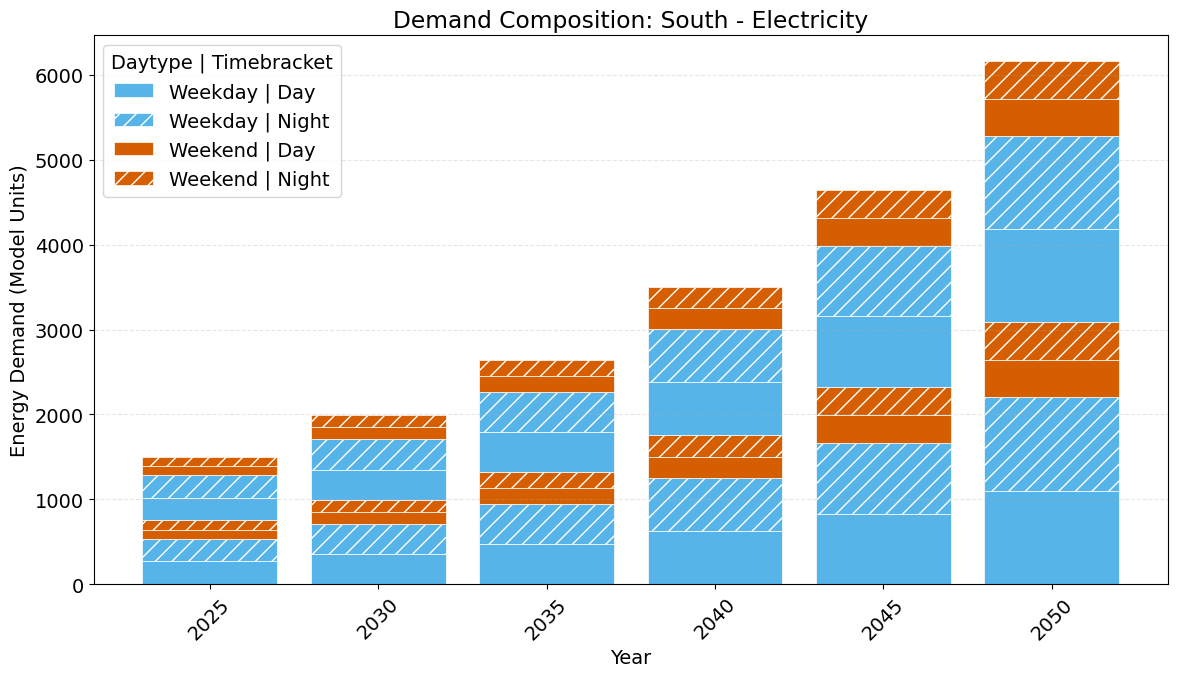

In [ ]:
demand1.visualize(region="North", fuel="Electricity")
demand1.visualize(region="East", fuel="Electricity")
demand1.visualize(region="South", fuel="Electricity")

### 4. Scenario 2: Annual and Subannual Demand

In [ ]:
# --- Scenario 2: Annual + Subannual Demand ---
scenario2_dir = os.path.join(DEMO_DIR, "scenario2")
os.makedirs(scenario2_dir, exist_ok=True)
demand2 = DemandComponent(scenario2_dir)

# Copy time component prerequisite from existing scenario (see demo.time.ipynb)
ScenarioComponent.copy("demo_output/time_component/uniform", scenario2_dir, overwrite=True)

# Add demand for each region and fuel
for i, region in enumerate(regions):
    for j, fuel in enumerate(fuels):
        # Create unique endpoints for each region x fuel
        start_val = 1000 + 500 * i + 250 * j
        end_val = 3000 + 500 * i + 250 * j
        trajectory = {2020: start_val, 2040: end_val}
        interp = "linear" if (i + j) % 2 == 0 else "cagr"
        demand2.add_annual_demand(region, fuel, years, trajectory, interpolation=interp)
        demand2.add_subannual_profile(region, fuel, timeslice_factor = {
                                        "Winter_Weekday_Day": (5/7)*0.8,
                                        "Winter_Weekday_Night": (5/7)*1.2,
                                        "Winter_Weekend_Day": (2/7)*0.6,
                                        "Winter_Weekend_Night": (2/7)*1.4}
        )
demand2.process()
demand2.save()

# Display the generated DataFrame
print("Annual Demand (Scenario 2):")
print(demand2.annual_demand_df.head())

In [ ]:
demand2.visualize(region="RegionA", fuel="NaturalGas")

In [ ]:
demand2.visualize(region="RegionA", fuel="NaturalGas")

### 5. Scenario 3: Annual, Subannual, and Flexible Demand

### 6. Visualizing Demand Scenarios
You can visualize the demand profiles for each scenario using the built-in `visualize` method.

In [ ]:
# Visualize demand for Scenario 1
for region in regions:
    for fuel in fuels:
        print(f"Scenario 1: {region}, {fuel}")
        demand1.visualize(region, fuel)

# Visualize demand for Scenario 2
for region in regions:
    for fuel in fuels:
        print(f"Scenario 2: {region}, {fuel}")
        demand2.visualize(region, fuel)